In [8]:
import sys
sys.path.insert(0, '..')
from pkg.nse import nse
import requests,json
import pandas as pd
import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
import yfinance as yf
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")
import seaborn

pd.core.common.is_list_like = pd.api.types.is_list_like
yf.pdr_override()

In [3]:
'GANESHHOUC',
'HUDCO'
'CGPOWER '
'JINDALSTEL'
'AMBER'
'KAYNES'
'SWSOLAR'
'IDFCFIRSTB'
'TATACHEM'
'BEL'
'ZOMATO'
'NH'
'TITAGARH'
'RVNL'
'PRAJIND'

'TITAGARH'

#### Fetching NSE symbol metadata

In [9]:
#we alsomhave ful details
symbols=pd.read_csv("./nse_symbols_metadata.json", index_col=0)

#### Fetching historical close dates

In [10]:
# symbols[symbols['industry']=='Banks']
# start_date = "2023-01-03"
# end_date ="2024-02-02"
# symbol='HDFCBANK'
def yf_symbol(s):
    return s+'.NS'

In [11]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [86]:
#end_date is excluded
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2019, 1, 1)
# tickers = [yf_symbol(i) for i in symbols[(symbols['industry']=='Banks')&(symbols['isFNOSec']==True) ]['symbol'].values]
#remove some bank because they listed after start date
tickers = [ 'AXISBANK.NS',  'BANKBARODA.NS', 'CANBK.NS', 'CUB.NS', 'FEDERALBNK.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'INDUSINDBK.NS', 'KOTAKBANK.NS', 'PNB.NS',  'SBIN.NS']
df = pdr.get_data_yahoo(tickers, start, end)['Adj Close']
df.tail()

[*********************100%%**********************]  11 of 11 completed


Ticker,AXISBANK.NS,BANKBARODA.NS,CANBK.NS,CUB.NS,FEDERALBNK.NS,HDFCBANK.NS,ICICIBANK.NS,INDUSINDBK.NS,KOTAKBANK.NS,PNB.NS,SBIN.NS
Date,,,,,,,,,,,
2018-12-24,612.678467,108.783890,49.550648,183.260941,89.553864,990.316833,345.922577,1517.496216,1235.456665,74.093460,275.831635
2018-12-26,617.161438,110.952026,50.397110,180.769257,88.264969,1010.164673,348.962585,1511.765625,1245.083008,75.107780,276.867035
2018-12-27,615.218750,109.726562,50.648258,180.866989,89.840279,1001.930420,348.766418,1519.098877,1237.202515,75.300980,274.984528
2018-12-28,622.690491,111.564758,51.615646,183.260941,89.028755,1010.426270,353.767761,1537.796265,1238.299683,75.783989,277.478821
2018-12-31,617.559937,111.988968,51.169155,190.589417,89.028755,1009.855225,353.179321,1553.385498,1253.412476,75.445885,278.514191


[('CUB.NS', 'HDFCBANK.NS'), ('ICICIBANK.NS', 'SBIN.NS')]


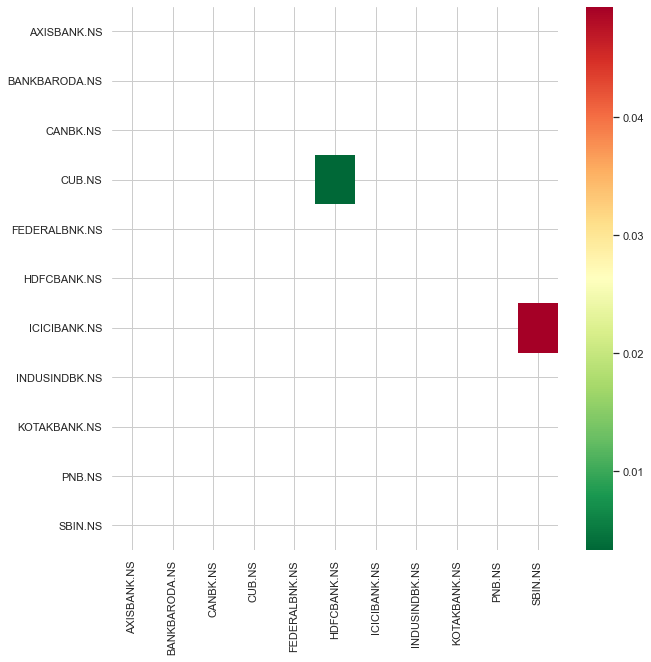

In [72]:
scores, pvalues, pairs = find_cointegrated_pairs(df)
fig, ax = plt.subplots(figsize=(10,10))
seaborn.heatmap(pvalues, xticklabels=df.columns, yticklabels=df.columns, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.05)
                )
print(pairs)



In [73]:
[('CUB.NS', 'HDFCBANK.NS'), ('ICICIBANK.NS', 'SBIN.NS')]

[('CUB.NS', 'HDFCBANK.NS'), ('ICICIBANK.NS', 'SBIN.NS')]

0.04935725916663411


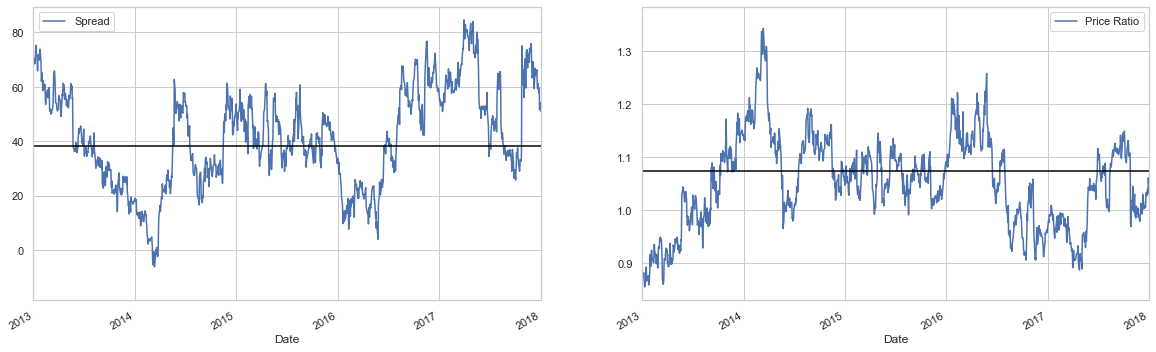

In [102]:
S1 = df['ICICIBANK.NS']
S2 = df['SBIN.NS']

score, pvalue, _ = coint(S1, S2)
print(pvalue)
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['ICICIBANK.NS']
b = results.params['ICICIBANK.NS']
#-----------------spread-----------------#
plt.subplot(1, 2, 1)
spread = S2 - b * S1
spread.plot(figsize=(20,6))
plt.axhline(spread.mean(), color='black')
plt.xlim('2013-01-01', '2018-01-01')
plt.legend(['Spread']);
#-----------------ratio-----------------#
plt.subplot(1, 2, 2)
ratio = S1/S2
ratio.plot(figsize=(20,6))
plt.axhline(ratio.mean(), color='black')
plt.xlim('2013-01-01', '2018-01-01')
plt.legend(['Price Ratio']);

In [103]:
score

-3.3408565187912624

##### price range axis > 1000 and fed > 150 and spread/resedual is moving in ranges if 20 then we can consider this relation

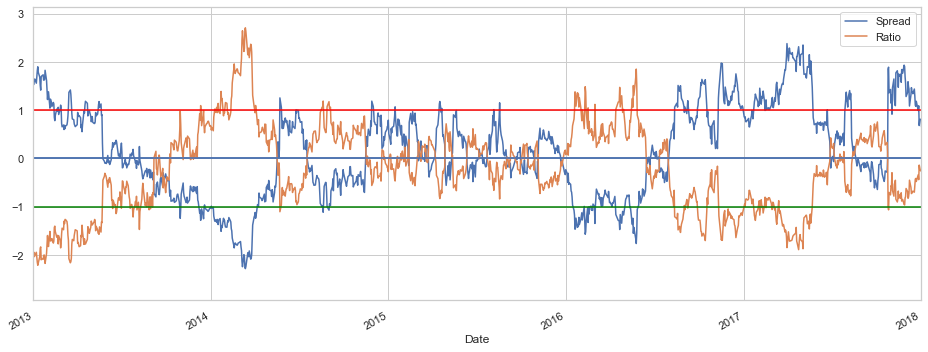

In [104]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

#-----------------spread-----------------#
ax=plt.subplot(1, 2, 1)
zscore(spread).plot(figsize=(35,6),label='Spread')
plt.axhline(zscore(spread).mean())
plt.xlim('2013-01-01', '2018-01-01')
#-----------------ratio-----------------#
ax=plt.subplot(1, 2, 1)
zscore(ratio).plot(figsize=(35,6),label='Ratio')
plt.axhline(zscore(ratio).mean())

plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.xlim('2013-01-01', '2018-01-01')
ax.legend()
plt.show()

In [105]:
print(len(spread) * .70 ) 
train = spread[:1034]
test = spread[1034:]

1034.6


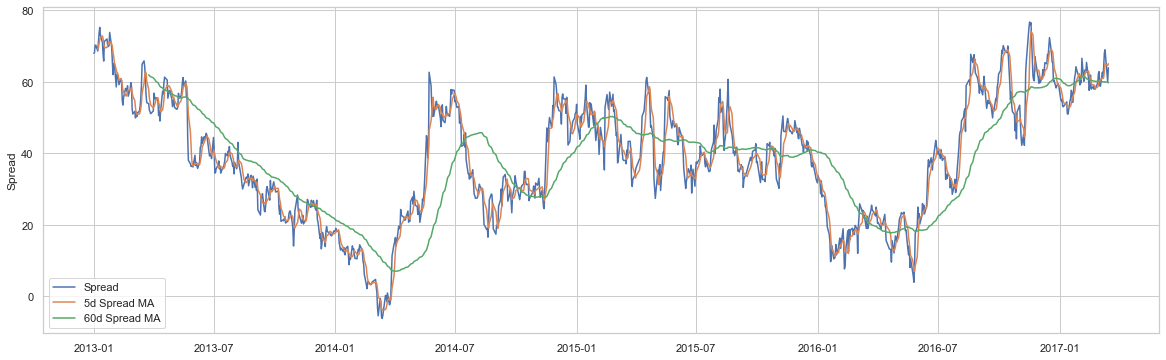

In [106]:
spreads_mavg5 = train.rolling(window=5, center=False).mean()
spreads_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (spreads_mavg5 - spreads_mavg60)/std_60
plt.figure(figsize=(20, 6))
plt.plot(train.index, train.values)
plt.plot(spreads_mavg5.index, spreads_mavg5.values)
plt.plot(spreads_mavg60.index, spreads_mavg60.values)
plt.legend(['Spread', '5d Spread MA', '60d Spread MA'])

plt.ylabel('Spread')
plt.show()

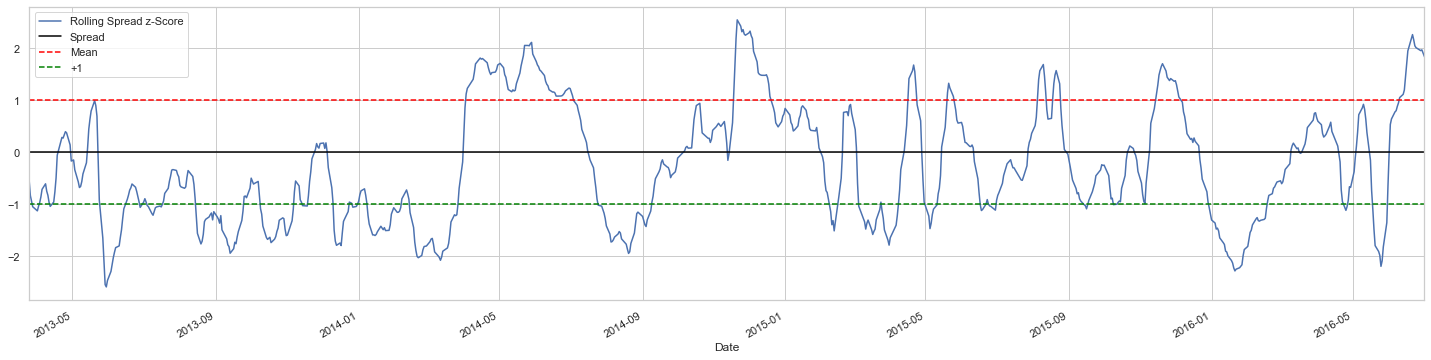

In [107]:
plt.figure(figsize=(25,6))
zscore_60_5.plot()
# zscore(spread).plot(figsize=(25,6),label='Spread')

plt.xlim('2013-03-25', '2016-07-01')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Spread z-Score','Spread' ,'Mean', '+1', '-1'])
plt.show()

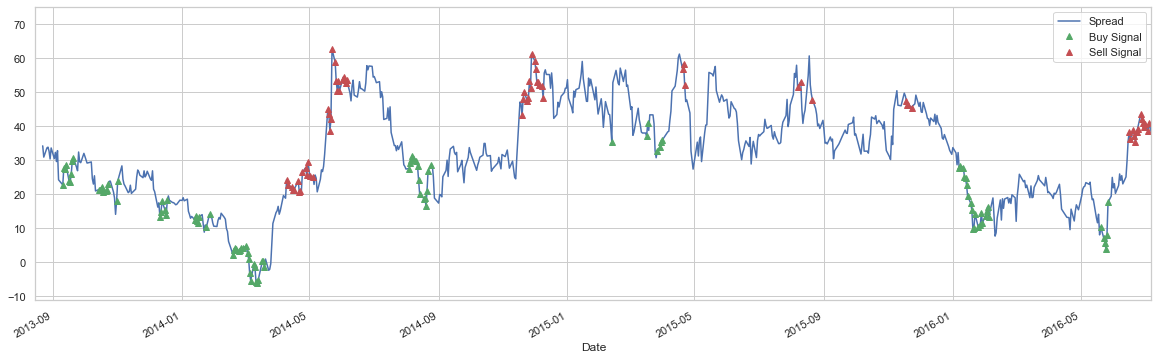

In [148]:
plt.figure(figsize=(20,6))

train[160:].plot()
buy = train.copy()
sell = train.copy()

buy[zscore_60_5>-1.5] = -100
sell[zscore_60_5<1.5] = -100

buy[160:].plot(color='g', linestyle='None', marker='^')
sell[160:].plot(color='r', linestyle='None', marker='^')

x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, spread.min()-5, spread.max()))
plt.xlim('2013-08-15','2016-07-07')
plt.legend(['Spread', 'Buy Signal', 'Sell Signal'])
plt.show()

In [149]:
b=1
# 0.7755261059030932

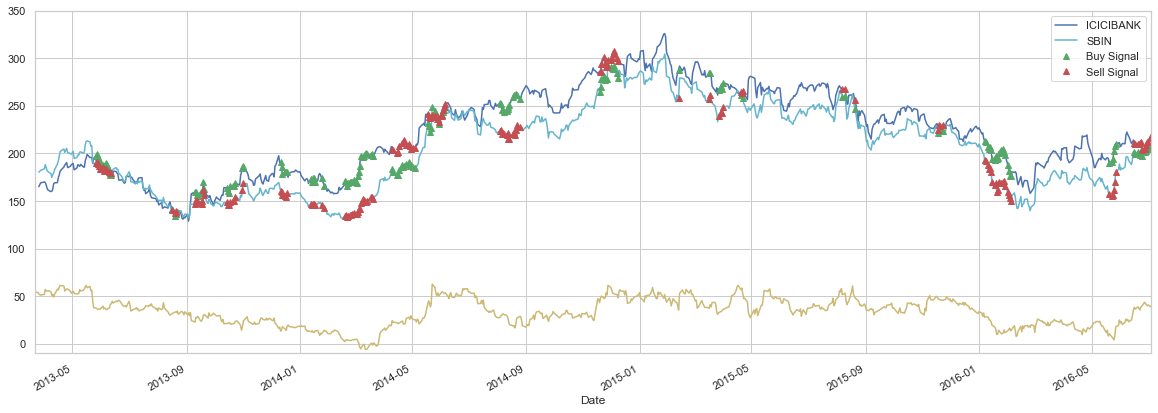

In [153]:
plt.figure(figsize=(20,7))
S1 = df['ICICIBANK.NS'].iloc[:881]
S2 = df['SBIN.NS'].iloc[:881]

(b*S1[60:]).plot(color='b')
S2[60:].plot(color='c')
buyR = -100*S1.copy()
sellR = -100*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=-100] = S1[buy!=-100]*b
sellR[buy!=-100] = S2[buy!=-100]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=-100] = S2[sell!=-100]
sellR[sell!=-100] = S1[sell!=-100]*b

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
plt.ylim(-10, 350)
plt.xlim('2013-03-22', '2016-07-04')

plt.legend(['ICICIBANK', 'SBIN', 'Buy Signal', 'Sell Signal'])
spread = (S2 - 0.7755261059030932 * S1)
spread.plot(color='y')
plt.show()

In [155]:
# Trade using a simple strategy
def trade(S1, S2, window1, window2,b=1):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    spread = b*S1-S2
    ma1 = spread.rolling(window=window1,
                               center=False).mean()
    ma2 = spread.rolling(window=window2,
                               center=False).mean()
    std = spread.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(spread)):
        # Sell short if the z-score is > 1
        if zscore[i] < -1.5:
            money += S2[i] - S1[i] * b
            countS2 -= 1
            countS1 += b
            #print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Buy long if the z-score is < -1
        elif zscore[i] > 1:
            money -= S1[i]*b - S2[i] 
            countS2 += 1.5
            countS1 -= b
            #print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            #print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))
            
            
    return money

In [156]:
trade(df['ICICIBANK.NS'].iloc[881:], df['SBIN.NS'].iloc[881:], 60, 5,b=0.7755261059030932)

40587.2413400031